## Efficient Object Detection with YOLOV8 and KerasCV

Model: `YOLOv8` - Ultralytics (the creator of YOLOv5, YOLOv8)
* There are five different YOLOv8 models with different sizes (measured in pixels): YOLOv8n, YOLOv8s, YOLOv8m, YOLOv8l, and YOLOv8x. The metrics include mean average precision (mAP) values at different intersection-over-union (IoU) thresholds for validation data, inference speed on CPU with ONNX format and A100 TensorRT, number of parameters, and number of floating-point operations (FLOPs) (both in millions and billions, respectively). YOLOv8x has the highest mAP, parameters, and FLOPs but also the slowest inference speed, while YOLOv8n has the smallest size, fastest inference speed, and lowest mAP, parameters, and FLOPs. ([Ultrlytics home](https://docs.ultralytics.com/))

Dataset: [Microcontroller Detection Dataset](https://www.kaggle.com/datasets/tannergi/microcontroller-detection)

Original Documentation Dataset

[Self-Driving Car Dataset](https://public.roboflow.com/object-detection/self-driving-car) from roboflow

This dataset originally consisted of 15000 datas samples. In this work we will use 7316 samples.
Writers reduced the number of object classes to 5 main classes for detection and classification ("car", "pedestrian", "traffic light", "biker", and "truck").

[Tensorflow Object Detection Datasets](https://www.tensorflow.org/datasets/catalog/overview#object_detection)

### Import KerasCV

In [1]:
!pip install --upgrade git+https://github.com/keras-team/keras-cv -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.1/880.1 kB 4.6 MB/s eta 0:00:00


In [2]:
import os
from tqdm.auto import tqdm
import xml.etree.ElementTree as ET

import tensorflow as tf
from tensorflow import keras

import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization

Using TensorFlow backend


### Hyperparametets

In [3]:
SPLIT_RATIO = 0.2
BATCH_SIZE = 4  # To avoid memory overflow
LEARNING_RATE = 0.001
EPOCH = 5
GLOBAL_CLIPNORM = 10.0

### Load Data

A dictionary is created to map each class name to a unique numerical identifier. This mapping is used to encode and decode the class labels during training and inference in object detection tasks.

In [7]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d tannergi/microcontroller-detection

mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/8.34M [00:00<?, ?B/s]
100% 8.34M/8.34M [00:00<00:00, 108MB/s]


In [8]:
import zipfile

# Unzip the downloaded file
def unzip_data(zip_file_name):
  zip_ref = zipfile.ZipFile(zip_file_name, "r")
  zip_ref.extractall()
  zip_ref.close()

In [9]:
unzip_data("/content/microcontroller-detection.zip")

In [10]:
class_ids = [
    "Arduino_Nano",
    "Heltec_ESP32_Lora",
    "ESP8266",
    "Raspberry_Pi_3",
]

In [11]:
class_mapping = dict(zip(range(len(class_ids)), class_ids))

In [12]:
class_mapping

{0: 'Arduino_Nano', 1: 'Heltec_ESP32_Lora', 2: 'ESP8266', 3: 'Raspberry_Pi_3'}

In [13]:
# Path to images and annotations
IMG_PATH = "/content/Microcontroller Detection/train"
ANNOT_PATH = "/content/Microcontroller Detection/train"

In [14]:
import os

def get_all_files_ext(path, ext, sort=True):
  '''Get all files with the given file extension in the given path'''
  ext = "." + str(ext)
  files = [
      os.path.join(path, file_name)
      for file_name in os.listdir(path)
      if file_name.endswith(ext)
  ]

  if sort == True:
    return sorted(files)
  else:
    return files

In [15]:
xml_files = get_all_files_ext(ANNOT_PATH, "xml")

In [16]:
jpg_files = get_all_files_ext(ANNOT_PATH, "jpg")

In [17]:
def parse_annotation(xml_file, img_path, class_mapping):
  '''
  Reads the XML file and finds the image name and path, iterates over each
  object in the XML file to extract the bounding box coordinates and class
  labels for each object.

  Returns:
  - The image path
  - List of bounding boxes (each represented as a list of four floats: xmin,
  ymin, xmax, ymax),
  - List of class IDs (represented as integers) corresponding to each bounding
  box. The class IDs are obtained by mapping the class labels to integer values
  using a dictionary called class_mapping.
  '''
  tree = ET.parse(xml_file)
  root = tree.getroot()

  image_name = root.find("filename").text
  image_path = os.path.join(img_path, image_name)

  boxes = []
  classes = []

  for obj in root.iter("object"):
    cls = obj.find("name").text
    classes.append(cls)

    bbox = obj.find("bndbox")

    xmin = float(bbox.find("xmin").text)
    ymin = float(bbox.find("ymin").text)
    xmax = float(bbox.find("xmax").text)
    ymax = float(bbox.find("ymax").text)

    boxes.append([xmin, ymin, xmax, ymax])

  class_ids = [
      list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
      for cls in classes
  ]
  return image_path, boxes, class_ids

In [18]:
image_paths = []
bbox = []
classes = []

for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file, IMG_PATH, class_mapping)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)

  0%|          | 0/142 [00:00<?, ?it/s]

### Ragged Tensors

Ragged Tnesors are the TensorFlow equivalent of nested variable-length lists. They allow the storage and processing of non-uniformly shaped data. Ragged tensors are used to create a tf.data.Dataset using the from_tensor_slices method. This method creates a dataset from the input tensors by slicing them along the first dimension. By using ragged tensors, the dataset can handle varying lengths of data for each image and provide a flexible input pipeline for further processing.

In [19]:
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

### Spliting data into Training and Validation sets

In [20]:
# Determine the number of validation samples
num_val = int(len(xml_files) * SPLIT_RATIO)

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)

### Data loading and bounding box formatting

Bounding boxes in KerasCV have a predetermined format. Bundle the bounding boxes into a dictionary that complies with the requirements listed below:

```python
bounding_boxes = {
    # num_boxes may be a Ragged dimension
    'boxes': Tensor(shape=[batch, num_boxes, 4]),
    'classes': Tensor(shape=[batch, num_boxes])
}
```
The dictionary has two keys, `'boxes'` and `'classes'`, each of which maps to a
TensorFlow RaggedTensor or Tensor object. The `'boxes'` Tensor has a shape of `[batch, num_boxes, 4]`, where batch is the number of images in the batch and num_boxes is the maximum number of bounding boxes in any image. The 4 represents the four values needed to define a bounding box:  `'xmin'`, `'ymin'`, `'xmax'`, `'ymax'`.

The `'classes'` Tensor has a shape of `[batch, num_boxes]`, where each element represents the class label for the corresponding bounding box in the `'boxes'` Tensor. The num_boxes dimension may be ragged, which means that the number of boxes may vary across images in the batch.

Final dict should be:
```python
{"images": images, "bounding_boxes": bounding_boxes}
```

In [21]:
def load_image(img_path):
  img = tf.io.read_file(img_path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [22]:
def load_dataset(img_path, classes, bbox):
    # Read Image
    image = load_image(img_path)

    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }

    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

Here we create a layer that resizes images to **640x640** pixels, while maintaining the original aspect ratio. The bounding boxes associated with the image are specified in the `xyxy` format. If necessary, the resized image will be padded with zeros to maintain the original aspect ratio.

Bounding Box Formats supported by KerasCV:
1.   CENTER_XYWH
2.   XYWH
3.   XYXY
4.   REL_XYXY
5.   REL_XYWH
6.   YXYX
7.   REL_YXYX


You can read more about KerasCV bounding box formats in
[docs](https://keras.io/api/keras_cv/bounding_box/formats/).

Furthermore, it is possible to perform format conversion between any two pairs:

```python
boxes = keras_cv.bounding_box.convert_format(
        bounding_box,
        images=image,
        source="xyxy",  # Original Format
        target="xywh",  # Target Format (to which we want to convert)
    )
```

### Data Augmentation

KerasCV provides native support for bounding box augmentation. KerasCV offers an
extensive collection of data augmentation layers specifically designed to handle bounding boxes. These layers intelligently adjust the bounding box coordinates as the image is transformed, ensuring that the bounding boxes remain accurate and aligned with the augmented images.

By leveraging KerasCV's capabilities, developers can conveniently integrate bounding box-friendly data augmentation into their object detection pipelines. By performing on-the-fly augmentation within a tf.data pipeline, the process becomes seamless and efficient, enabling better training and more accurate object detection results.

In [23]:
IMG_SIZE = (640, 640)

In [24]:
aug_layer = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"),
        # This layer will apply random shearings to each image, filling empty
        # space according to fill_mode. By default, random shears are only
        # applied during training.
        keras_cv.layers.JitteredResize(target_size=IMG_SIZE, scale_factor=(0.75, 1.3), bounding_box_format="xyxy"),
        # implements resize with scale distortion
    ]
)

### Create Training Dataset

In [25]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(aug_layer, num_parallel_calls=tf.data.AUTOTUNE)

### Create Validation Dataset

In [26]:
resizing_layer = keras_cv.layers.JitteredResize(
    target_size=IMG_SIZE,
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy",
)

In [27]:
val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing_layer, num_parallel_calls=tf.data.AUTOTUNE)

### Visualization

In [28]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )

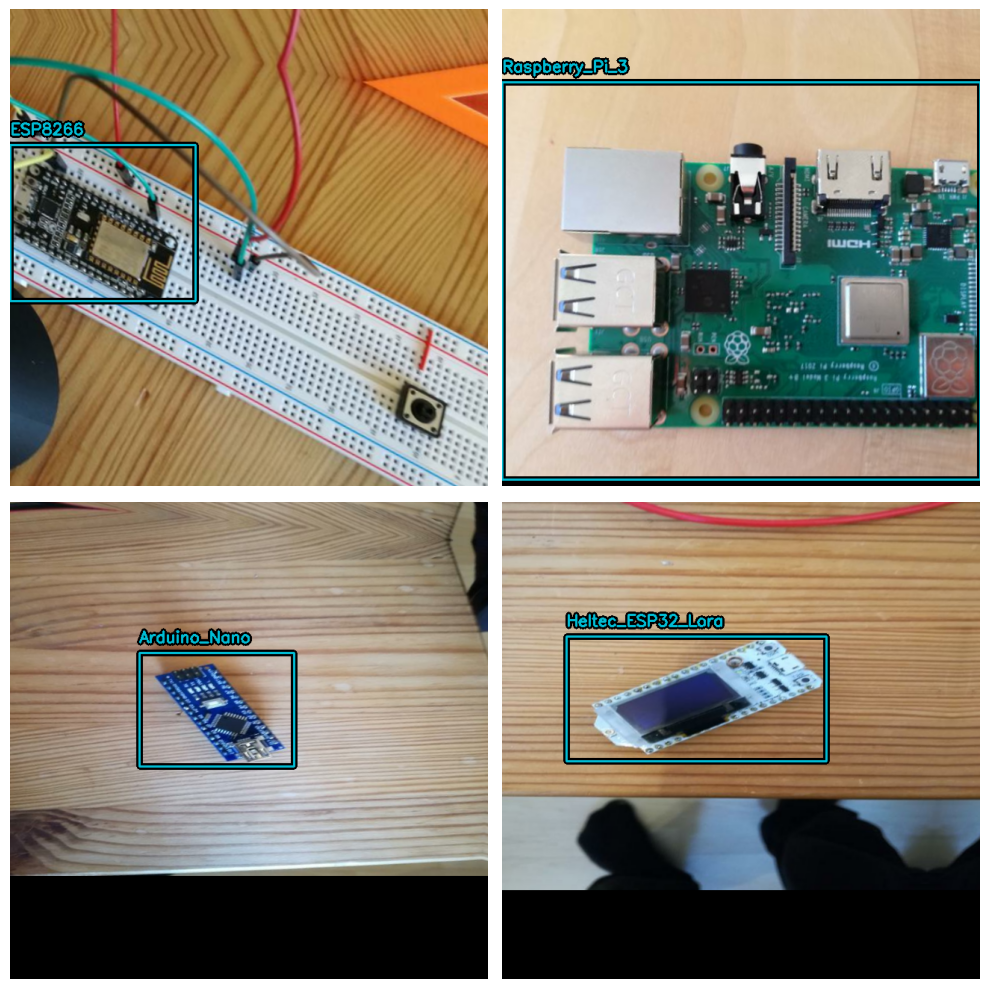

In [29]:
visualize_dataset(train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2)

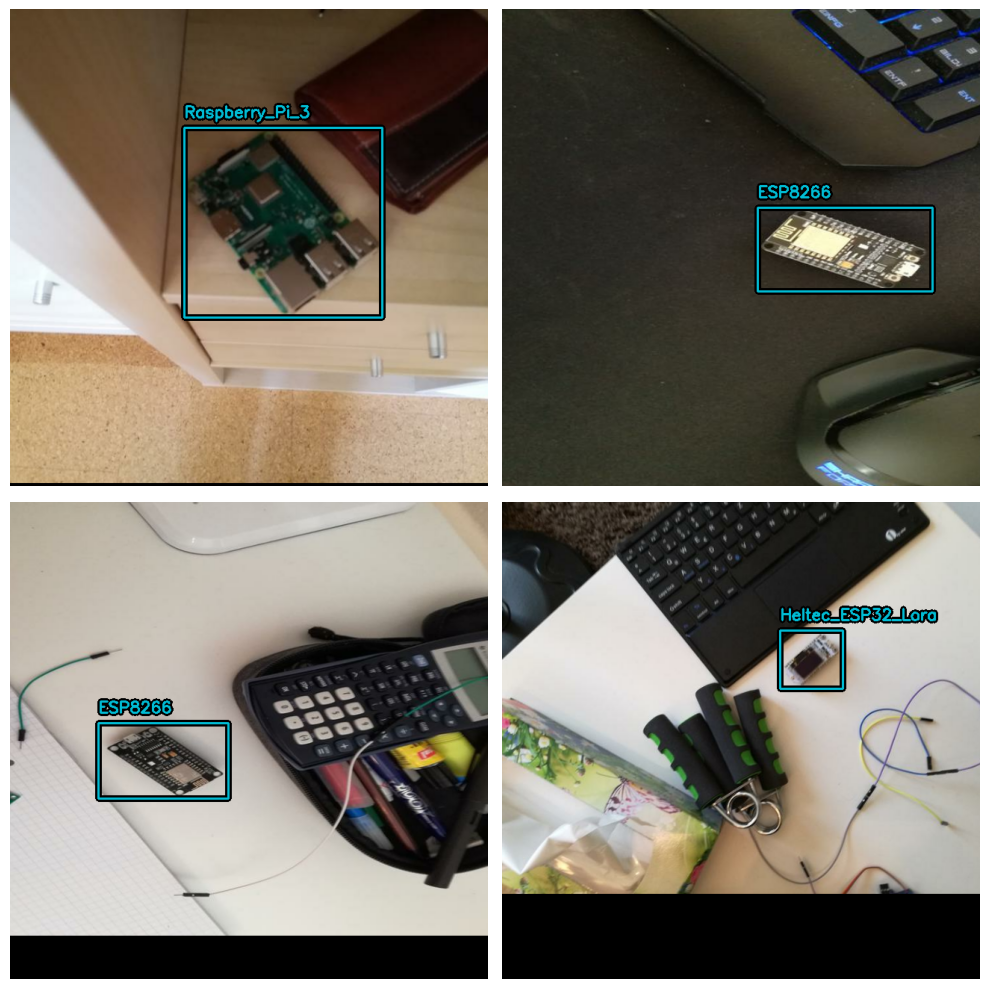

In [30]:
visualize_dataset(val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2)

We need to extract the inputs from the preprocessing dictionary and get them ready to be fed into the model.



In [31]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]

In [32]:
train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

In [33]:
val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

### Create Model

YOLOV8 Backbones available in KerasCV:

1.   Without Weights:

    1.   yolo_v8_xs_backbone
    2.   yolo_v8_s_backbone
    3.   yolo_v8_m_backbone
    4.   yolo_v8_l_backbone
    5.   yolo_v8_xl_backbone

2. With Pre-trained coco weight:

    1.   yolo_v8_xs_backbone_coco
    2.   yolo_v8_s_backbone_coco
    2.   yolo_v8_m_backbone_coco
    2.   yolo_v8_l_backbone_coco
    2.   yolo_v8_xl_backbone_coco

In [34]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco"  # We will use yolov8 small backbone with coco weights
)

20596968/20596968 [==============================] - 0s 0us/step


Next, let's build a YOLOV8 model using the `YOLOV8Detector`, which accepts a feature
extractor as the `backbone` argument, a `num_classes` argument that specifies the number
of object classes to detect based on the size of the `class_mapping` list, a
`bounding_box_format` argument that informs the model of the format of the bbox in the
dataset, and a finally, the feature pyramid network (FPN) depth is specified by the
`fpn_depth` argument.

It is simple to build a YOLOV8 using any of the aforementioned backbones thanks to
KerasCV.

In [35]:
yolo_v8 = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),  # the number of object classes to detect based on the size of the class_mapping
    bounding_box_format="xyxy",  # informs the model of the format of the bbox in the dataset
    backbone=backbone,
    fpn_depth=1,  # feature pyramid network (FPN) depth
)

### Compile the Model

Loss used for YOLOV8


1. **Classification Loss**: This loss function calculates the discrepancy between anticipated class probabilities and actual class probabilities. In this instance, `binary_crossentropy`, a prominent solution for binary classification issues, is utilized. We utilized binary crossentropy since each thing that is identified is either classed as belonging to or not belonging to a certain object class (such as a person, a car, etc.).

2. **Box Loss**: `box_loss` is the loss function used to measure the difference between the predicted bounding boxes and the ground truth. In this case, the Complete IoU (`CIoU`) metric is used, which not only measures the overlap between predicted and ground truth bounding boxes but also considers the difference in `aspect ratio`, `center distance`, and `box size`. Together, these loss functions help optimize the model for object detection by minimizing the difference between the predicted and ground truth class probabilities and bounding boxes.

In [36]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,  # If set, the gradient of all weights is
    # clipped so that their global norm is no higher than this value.
)

In [37]:
yolo_v8.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

### COCO Metric Callback

`BoxCOCOMetrics` from KerasCV will be used to evaluate the model and calculate the Map (`Mean Average Precision`) score, Recall and Precision. We also save our model when the mAP score improves.

In [38]:
# from collections import defaultdict

class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        # self.data = defaultdict(list)
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs

### Train the YOLOv8 Model

In [39]:
EPOCHS = 20

In [40]:
yolo_v8.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[EvaluateCOCOMetricsCallback(val_ds, "model.h5")],
)

Epoch 1/20
28/28 [==============================] - ETA: 0s - loss: 374.7263 - box_loss: 2.6327 - class_loss: 372.0936

28/28 [==============================] - 87s 908ms/step - loss: 374.7263 - box_loss: 2.6327 - class_loss: 372.0936 - val_loss: 26791.5801 - val_box_loss: 4.9926 - val_class_loss: 26786.5898 - MaP: 5.1928e-06 - MaP@[IoU=50]: 2.5964e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 8.7301e-06 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0071 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0083
Epoch 2/20
28/28 [==============================] - 19s 669ms/step - loss: 165.2785 - box_loss: 2.6796 - class_loss: 162.5989 - val_loss: 2105.6536 - val_box_loss: 4.5219 - val_class_loss: 2101.1316 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detecti

28/28 [==============================] - 26s 915ms/step - loss: 3.8229 - box_loss: 2.4100 - class_loss: 1.4129 - val_loss: 5.6867 - val_box_loss: 3.6030 - val_class_loss: 2.0837 - MaP: 1.7924e-04 - MaP@[IoU=50]: 8.9621e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 1.7924e-04 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0100 - Recall@[max_detections=100]: 0.0100 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0100
Epoch 9/20
28/28 [==============================] - 19s 652ms/step - loss: 3.7278 - box_loss: 2.3755 - class_loss: 1.3522 - val_loss: 4.0429 - val_box_loss: 2.6551 - val_class_loss: 1.3878 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Reca

28/28 [==============================] - 23s 805ms/step - loss: 3.4010 - box_loss: 2.2350 - class_loss: 1.1660 - val_loss: 36.6054 - val_box_loss: 2.7971 - val_class_loss: 33.8083 - MaP: 6.4356e-04 - MaP@[IoU=50]: 0.0021 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 6.4356e-04 - Recall@[max_detections=1]: 0.0188 - Recall@[max_detections=10]: 0.0188 - Recall@[max_detections=100]: 0.0188 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0188
Epoch 15/20
28/28 [==============================] - 20s 695ms/step - loss: 3.3733 - box_loss: 2.2663 - class_loss: 1.1070 - val_loss: 4.5945 - val_box_loss: 3.2401 - val_class_loss: 1.3544 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[m

### Visualize Predictions

In [41]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=False,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

1/1 [==============================] - 0s 227ms/step


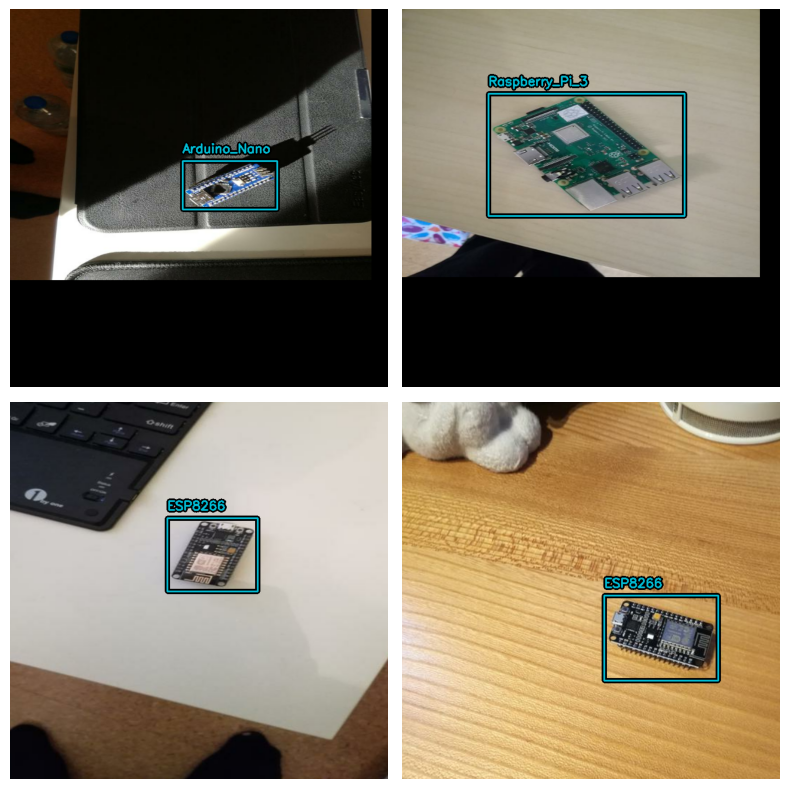

In [42]:
visualize_detections(yolo_v8, dataset=val_ds, bounding_box_format="xyxy")

### Reference

https://keras.io/examples/vision/yolov8/#introduction

https://github.com/keras-team/keras-io/blob/master/examples/vision/yolov8.py